Para probar como funciona un modelo de Regresión Lineal, vamos a emplear el dataset Ecommerce Customers.csv que podéis encontrar en GitHub. En este dataset tenéis una serie de parámetros sobre clientes de una tienda online:
*   Email	Address
*   Avatar (color del avatar)
*   Avg. Session Length	Time on App
*   Time on Website
*   Length of Membership
*   Yearly Amount Spent

El objetivo de nuestro trabajo será predecir cuánto gastará anualmente un cliente en dicha tienda (variable dependiente) en función del resto de las variables.

Comenzamos cargando librerías y datos.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Cargar los datos desde GitHub
url = 'https://raw.githubusercontent.com/crisurdiales/DataMining4SmartCities/main/Ecommerce%20Customers.csv'
df = pd.read_csv(url)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Email                 500 non-null    object 
 1   Address               500 non-null    object 
 2   Avatar                500 non-null    object 
 3   Avg. Session Length   500 non-null    float64
 4   Time on App           500 non-null    float64
 5   Time on Website       500 non-null    float64
 6   Length of Membership  500 non-null    float64
 7   Yearly Amount Spent   500 non-null    float64
dtypes: float64(5), object(3)
memory usage: 31.4+ KB
None


Se puede observar que la dirección de email, la dirección física y el color del avatar con datos tipo objeto. Es más, los dos primeros tienen demasiados valores posibles y ninguno de los tres parece relevante para la predicción, así que los descartaremos.

In [2]:
# Eliminar las columnas de texto
df = df.drop(columns=['Email', 'Address','Avatar'])

# Actualizar nombres de las columnas basados en la inspección
numeric_columns = ['Avg. Session Length', 'Time on App', 'Time on Website', 'Length of Membership', 'Yearly Amount Spent']
print(df.head())

   Avg. Session Length  Time on App  Time on Website  Length of Membership  \
0            34.497268    12.655651        39.577668              4.082621   
1            31.926272    11.109461        37.268959              2.664034   
2            33.000915    11.330278        37.110597              4.104543   
3            34.305557    13.717514        36.721283              3.120179   
4            33.330673    12.795189        37.536653              4.446308   

   Yearly Amount Spent  
0           587.951054  
1           392.204933  
2           487.547505  
3           581.852344  
4           599.406092  


Antes de proceder, podemos comprobar si existe algún tipo de relación entre las variables con las que trabajamos. Podemos ver que siguen distribuciones unimodales y que en algunos casos se tiende a relaciones más o menos lineales, como por ejemplo el tiempo de membresía y el gasto anual.

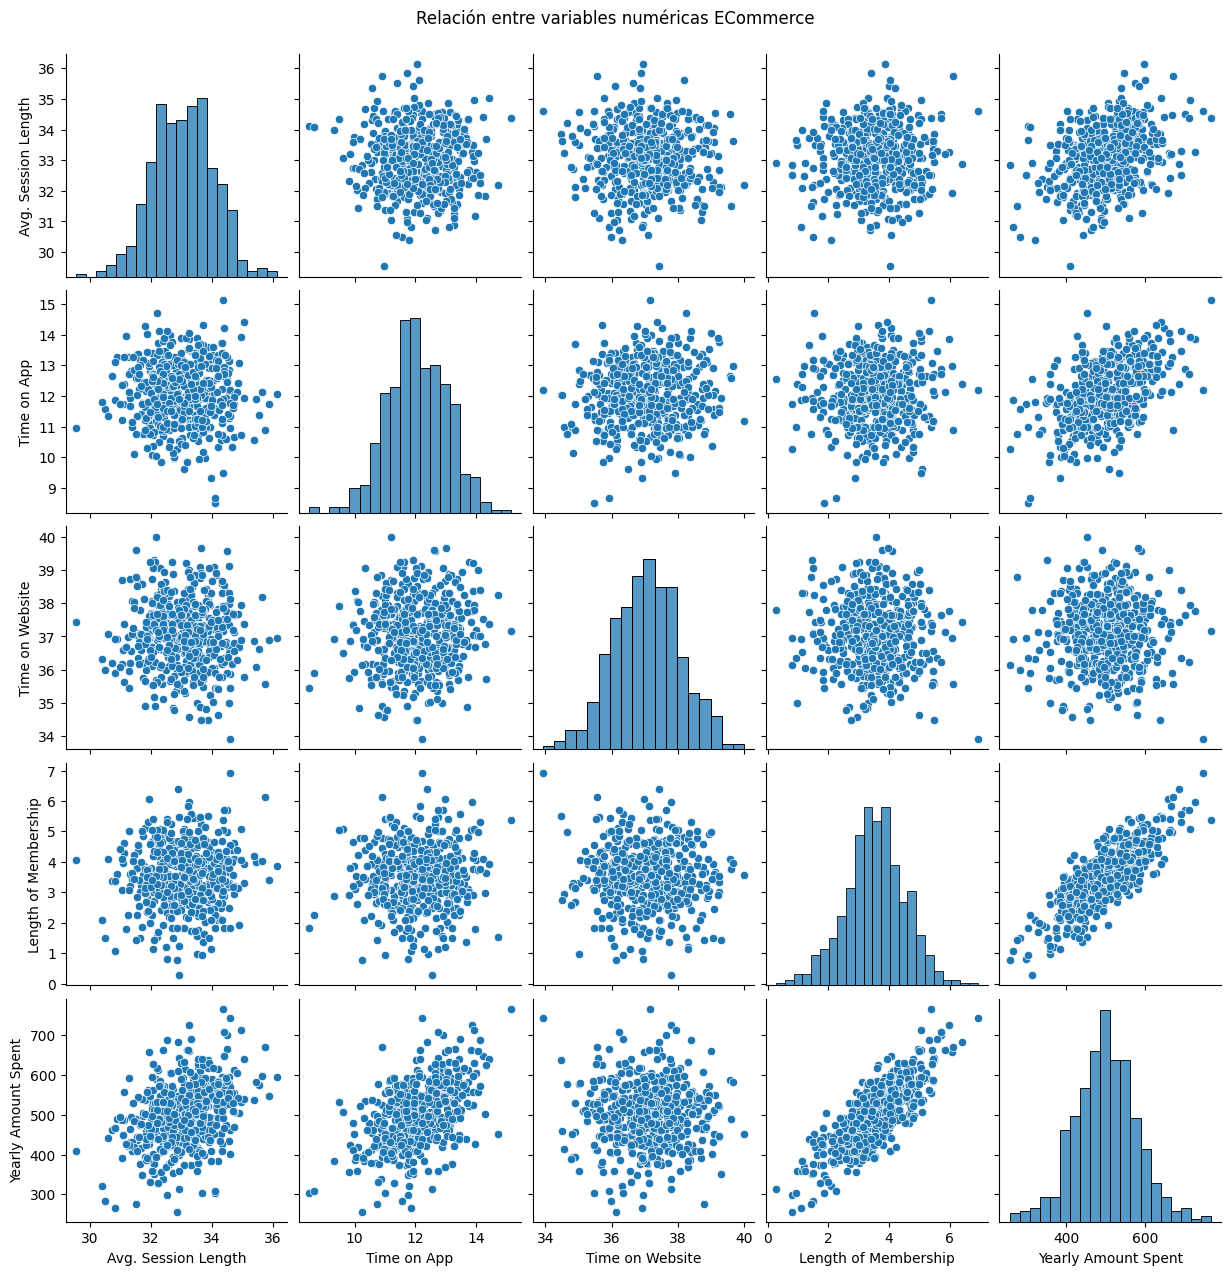

In [3]:
# Relaciones entre variables
sns.pairplot(df, vars=numeric_columns)
plt.suptitle('Relación entre variables numéricas ECommerce', y=1.02)
plt.show()

A continuación, ajustaremos modelos lineales independientes a cada una de las variables de entrada por separado y los evaluaremos.

In [4]:
# Ajustar modelos de regresión lineal
X_sesion = sm.add_constant(df['Avg. Session Length'])
X_membresia = sm.add_constant(df['Length of Membership'])
X_app = sm.add_constant(df['Time on App'])
X_web = sm.add_constant(df['Time on Website'])
y = df['Yearly Amount Spent']

model_sesion = sm.OLS(y, X_sesion).fit()
model_membresia = sm.OLS(y, X_membresia).fit()
model_app = sm.OLS(y, X_app).fit()
model_web = sm.OLS(y, X_web).fit()


Comprobemos primero los coeficientes de los modelos. La aproximacion lineal es obviamente y= (Intercept) + varindep*x donde
* intercept: es el valor de la variable dependiente si la independiente es cero (corte x)
* (nombre de variable independiente): es la pendiente de la recta para la variable,i.e por cada incremento de x cuanto varia y

In [5]:
# Coeficientes del modelo
print(model_sesion.params)
print(model_membresia.params)
print(model_app.params)
print(model_web.params)

const                 -438.562744
Avg. Session Length     28.374771
dtype: float64
const                   272.399786
Length of Membership     64.218684
dtype: float64
const          19.209312
Time on App    39.834491
dtype: float64
const              506.996070
Time on Website     -0.207284
dtype: float64


Con los coeficientes, resulta sencillo predecir la variable dependiente en función de cualquiera de las variables independientes que tenemos. Por ejemplo, a partir del modelo de membresía, una persona que lleva 4 años en el comercio tendría un gasto anual de 549.3 EUR.

In [ ]:
# Predicción con el modelo de tiempo de membresía
prediction = model_membresia.predict([1, 4])  # 4 años de membresía
print(f'Predicción de gasto anual para 4 años de membresía: {prediction[0]}')

Predicción de gasto anual para 4 años de membresía: 529.2745233203656


Pasamos ahora a evaluar los modelos para las cuatro variables independientes que tenemos.

In [6]:
# Resumen de los modelos
print("**Modelo de tiempo medio de sesión")
print(model_sesion.summary())
print("**Modelo de tiempo de membresía")
print(model_membresia.summary())
print("**Modelo de tiempo en la app")
print(model_app.summary())
print("**Modelo de tiempo en la web")
print(model_web.summary())


**Modelo de tiempo medio de sesión
                             OLS Regression Results                            
Dep. Variable:     Yearly Amount Spent   R-squared:                       0.126
Model:                             OLS   Adj. R-squared:                  0.124
Method:                  Least Squares   F-statistic:                     71.85
Date:                 Mon, 27 May 2024   Prob (F-statistic):           2.65e-16
Time:                         09:38:54   Log-Likelihood:                -2862.0
No. Observations:                  500   AIC:                             5728.
Df Residuals:                      498   BIC:                             5736.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

Si evaluamos los modelos, podemos observar que tienen distinta tasa de error y, además, que en dos casos puede haber problemas de multicolinealidad, lo cual era de esperar, en tanto que no se ha hecho ningún estudio previo al respecto y algunas variables están claramente relacionadas.

Interpretemos los principales resultados del resumen:

* Dep. Variable: La variable dependiente que se está modelando.

* Model: El tipo de modelo que se ha ajustado (en este caso, OLS - Ordinary Least Squares).

* Method: El método usado para ajustar el modelo (en este caso, Mínimos Cuadrados).

* No. Observations: El número de observaciones (datos) utilizados en el modelo.

* Df Residuals: Los grados de libertad de los residuos, calculados como el número de observaciones menos el número de parámetros estimados.

* Df Model: Los grados de libertad del modelo, generalmente igual al número de parámetros estimados menos uno (el intercepto).

* R-squared: El coeficiente de determinación, que indica la proporción de la variabilidad en la variable dependiente que puede ser explicada por las variables independientes. Un valor de 1 indica un ajuste perfecto.

* Adj. R-squared: El R-cuadrado ajustado, que ajusta el R-cuadrado en función del número de variables en el modelo. Es una medida más precisa del poder explicativo del modelo cuando hay múltiples variables independientes.

* F-statistic: La estadística F para el modelo, que evalúa la hipótesis nula de que todos los coeficientes de las variables independientes son iguales a cero o lo que es lo mismo, que las variables independientes no tienen efecto sobre la variable dependiente. Un valor bajo sugiere que las variables independientes no aportan una mejora significativa al ajuste del modelo. Este valor se lee combinado con el siguiente

* Prob (F-statistic): El valor p asociado a la estadística F. Un valor p bajo (típicamente < 0.05) indica que al menos una de las variables independientes es significativamente diferente de cero, es decir, sirve como predictor.

* Log-Likelihood: El logaritmo de la verosimilitud del modelo ajustado. Un valor más alto de Log-Likelihood indica un mejor ajuste del modelo a los datos.

* AIC: El criterio de información de Akaike, que evalúa la calidad del modelo teniendo en cuenta tanto el ajuste como la complejidad del modelo. Un valor menor indica un modelo mejor.

* BIC: El criterio de información bayesiano, similar al AIC pero con una penalización mayor por el número de parámetros. Un valor más alto de BIC indica un modelo que es menos preferible, ya sea porque no ajusta tan bien a los datos o porque es innecesariamente complejo.

* Coef: Muestra los coeficientes estimados del modelo. Cuando predecimos sólo con una variable, como es el caso, serán sólo el intercepto (const) y la pendiente de la variable independiente.

* std err: El error estándar de los coeficientes, que mide la variabilidad de la estimación de los coeficientes.

* t: La estadística t para cada coeficiente, calculada como el coeficiente dividido por su error estándar, que se utiliza para probar la hipótesis nula de que el coeficiente es igual a cero.

* P>|t|: El valor p asociado a la estadística t, que indica si el coeficiente es significativamente diferente de cero. Un valor p bajo (típicamente < 0.05) indica significancia estadística.

* [0.025, 0.975]: El intervalo de confianza al 95% para los coeficientes, indicando el rango en el que se espera que esté el coeficiente verdadero con un 95% de confianza.

* Omnibus: La estadística Omnibus para la normalidad de los residuos. Evalúa si los residuos del modelo siguen una distribución normal.

* Prob(Omnibus): El valor p asociado a la estadística Omnibus. Un valor p alto sugiere que los residuos son aproximadamente normales.

* Skew: La asimetría de los residuos. Una distribución simétrica tiene un skew de 0.

* Kurtosis: La curtosis de los residuos. Una distribución normal tiene una curtosis de 3.

* Durbin-Watson: La estadística de Durbin-Watson, que evalúa la autocorrelación de los residuos. Un valor cercano a 2 sugiere que no hay autocorrelación.

* Jarque-Bera (JB): La estadística Jarque-Bera para la normalidad de los residuos.

* Prob(JB): El valor p asociado a la estadística Jarque-Bera. Un valor p alto sugiere que los residuos son aproximadamente normales.

* Cond. No.: El número de condición del modelo, que evalúa la multicolinealidad. Un valor alto sugiere problemas de multicolinealidad.



Los residuos, que representan los errores de ajuste del mdeolo, son útiles para evaluar la calidad del ajuste del mismo. Un buen modelo de regresión tendrá residuos pequeños y aleatorios, distribuidos alrededor de cero. Si los residuos muestran un patrón sistemático o no aleatorio, podría indicar que el modelo no está capturando completamente la estructura de los datos.

Podemos representar los de nuestros modelos para comprobar gráficamente su distribución.

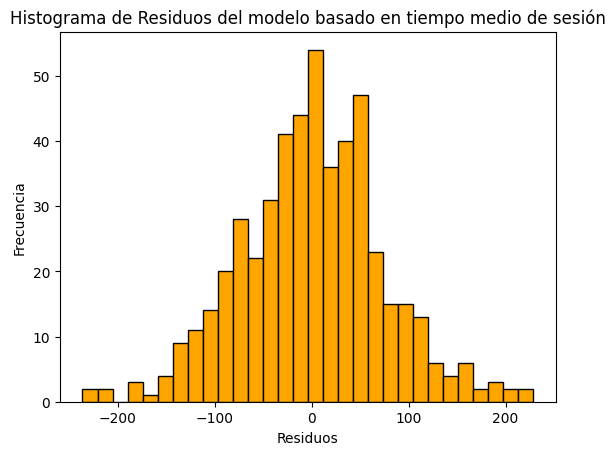

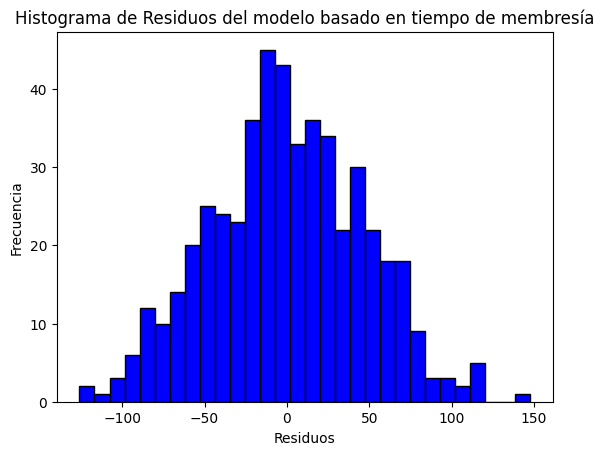

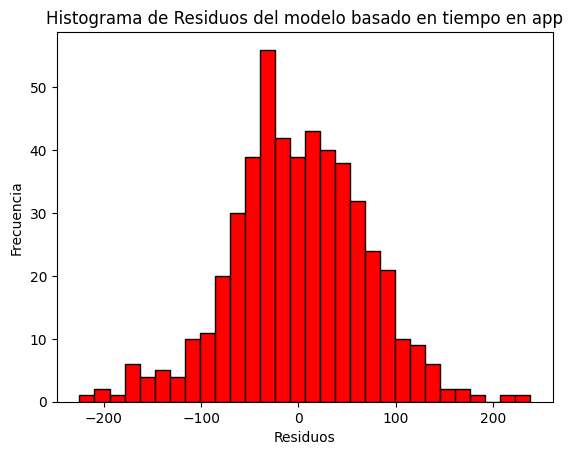

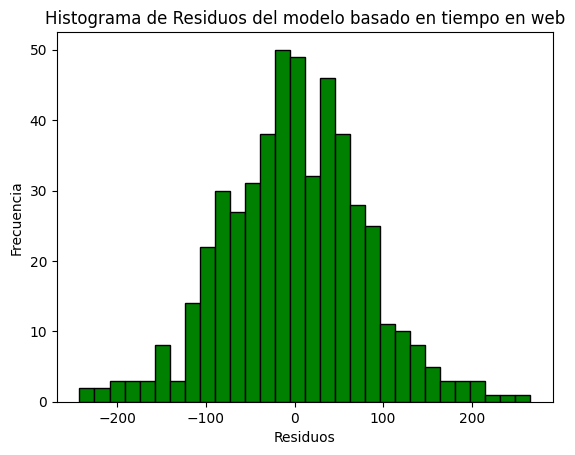

In [7]:
# Histograma de los residuos
def plot_residuals(model, title, color):
    residuals = model.resid
    plt.hist(residuals, bins=30, color=color, edgecolor='black')
    plt.title(f'Histograma de Residuos del modelo basado en {title}')
    plt.xlabel('Residuos')
    plt.ylabel('Frecuencia')
    plt.show()
plot_residuals(model_sesion, 'tiempo medio de sesión', 'orange')
plot_residuals(model_membresia, 'tiempo de membresía', 'blue')
plot_residuals(model_app, 'tiempo en app', 'red')
plot_residuals(model_web, 'tiempo en web', 'green')


Finalmente, vamos a representar gráficamente los modelos ajustados en los cuatro casos. Resulta obvio que en dos de ellos la aproximación lineal podría ser aceptable, pero en otros dos resulta poco adecuada.

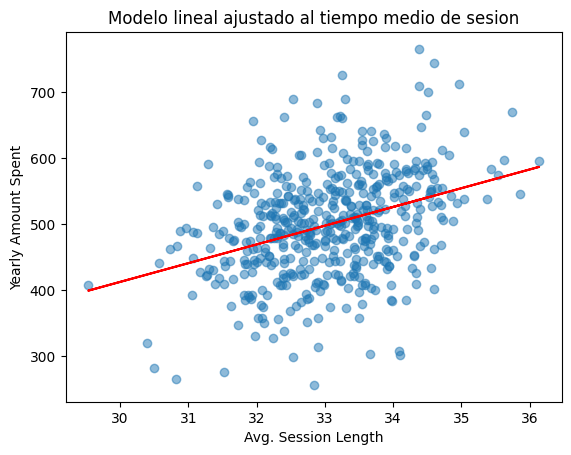

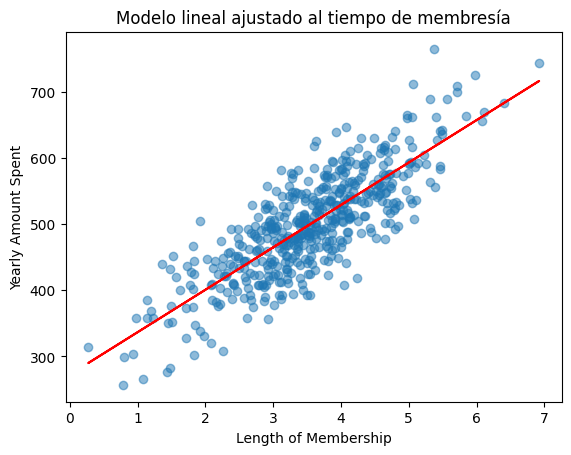

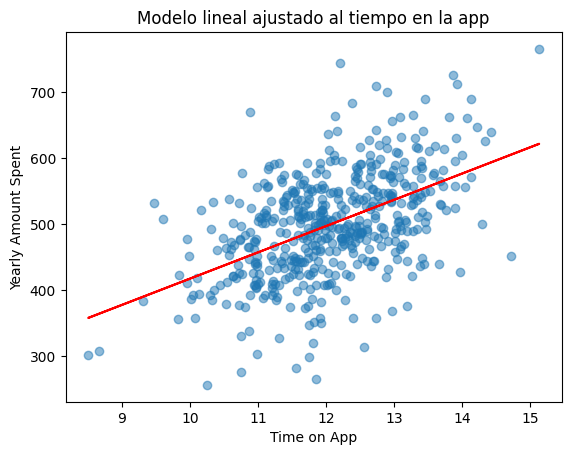

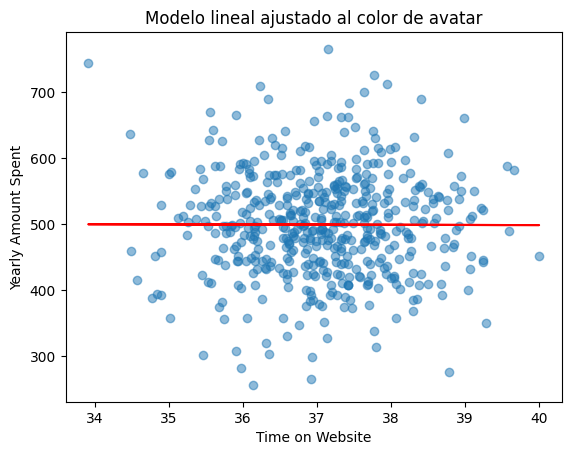

In [ ]:
# Graficar modelos ajustados
def plot_regression_line(x, y, model, title):
    plt.scatter(x, y, alpha=0.5)
    plt.plot(x, model.fittedvalues, color='red')
    plt.xlabel(x.name)
    plt.ylabel('Yearly Amount Spent')
    plt.title(title)
    plt.show()
plot_regression_line(df['Avg. Session Length'], y, model_sesion, 'Modelo lineal ajustado al tiempo medio de sesion')
plot_regression_line(df['Length of Membership'], y, model_membresia, 'Modelo lineal ajustado al tiempo de membresía')
plot_regression_line(df['Time on App'], y, model_app, 'Modelo lineal ajustado al tiempo en la app')
plot_regression_line(df['Time on Website'], y, model_web, 'Modelo lineal ajustado al color de avatar')

Hasta ahora hemos simplificado los modelos para que la predicción dependa de una sola variable independiente, pero los modelos lineales se pueden ajustar a varias variables en la forma:
y = (intercept) + var1*x1+ var2*x2 + ... varn*xn + ϵ

Para que uno de estos modelos sea válido, debe existir una relación lineal entre la variable dependiente y cada una de las independientes y, además, es necesario que las independientes no estén muy correladas entre si. Por ello, vamos a crear un modelo con dos variables usando el tiempo de membresía y el tiempo medio en la app. Adicionalmente, es deseable que la varianza de los residuos sea constante, que las observaciones sean independientes entre ellas y que la distribución de los residuos sea normal.

In [8]:
# Modelo con múltiples variables
X_total = df[['Length of Membership', 'Time on App']]
X_total = sm.add_constant(X_total) #añadir una constante para poder calcular el intercepto
model_total = sm.OLS(y, X_total).fit()
print(model_total.summary())


                             OLS Regression Results                            
Dep. Variable:     Yearly Amount Spent   R-squared:                       0.881
Model:                             OLS   Adj. R-squared:                  0.881
Method:                  Least Squares   F-statistic:                     1842.
Date:                 Mon, 27 May 2024   Prob (F-statistic):          1.38e-230
Time:                         09:55:07   Log-Likelihood:                -2363.2
No. Observations:                  500   AIC:                             4732.
Df Residuals:                      497   BIC:                             4745.
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 

Ahora para hacer predicción empleamos dos parámetros en el nuevo modelo: membresia y tiempo en la app. Podemos comprobar que ambos tienen peso en la predicción manteniendo uno constante y variando el otro.

In [12]:
# Predicciones con el modelo total
pred_1 = model_total.predict([1, 4, 8])  # 4 años de membresía y 8 horas en la app
pred_2 = model_total.predict([1, 4, 15]) # 4 años de membresía y 15 horas en la app

print(f'Predicción para 4 años de membresía y 8 horas en la app: {pred_1[0]}')
print(f'Predicción para 4 años de membresía y 15 horas en la app: {pred_2[0]}')

Predicción para 4 años de membresía y 8 horas en la app: 374.8239816727123
Predicción para 4 años de membresía y 15 horas en la app: 640.7240682836704


Podemos comparar el ajuste de este nuevo modelo de dos variables con los anteriores, por ejemplo, mediante el R-cuadrado ajustado. Es inmediato comprobar que los resultados son significativamente mejores en este último caso.

In [11]:
# Comparación de R-cuadrado ajustado
models = {
    'sesion': model_sesion,
    'membresía': model_membresia,
    'app': model_app,
    'web': model_web,
    'completo': model_total
}

for name, model in models.items():
    print(f'{name}: {model.rsquared_adj}')




sesion: 0.12433285305653152
membresía: 0.6539226786821504
app: 0.24782084889825173
web: -0.0020010440637936444
completo: 0.8806674346151216
Predicción para 4 años de membresía y 8 horas en la app: 374.8239816727123
Predicción para 4 años de membresía y 15 horas en la app: 640.7240682836704


Por último, y al incluir el modelo sólo dos variables independientes, podemos representar gráficamente en 3D el plano de ajuste del mismo y los vectores que estamos ajustando. En la gráfica a continuación se puede comprobar que se distribuyen bastante adecuadamente sobre el plano.

In [14]:
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import statsmodels.api as sm

# Supongo que ya tienes df y el modelo ajustado model_total

# Crear la malla para los valores predichos
Membresía = np.linspace(df['Length of Membership'].min(), df['Length of Membership'].max(), 100)
TiempoApp = np.linspace(df['Time on App'].min(), df['Time on App'].max(), 100)
Membresía, TiempoApp = np.meshgrid(Membresía, TiempoApp)
Gasto = model_total.predict(sm.add_constant(pd.DataFrame({
    'Length of Membership': Membresía.ravel(),
    'Time on App': TiempoApp.ravel()
})).values).reshape(Membresía.shape)

# Crear el gráfico de superficie
fig = go.Figure(data=[go.Surface(z=Gasto, x=Membresía, y=TiempoApp, colorscale='Viridis', opacity=0.7)])

# Agregar los puntos del dataframe original
fig.add_trace(go.Scatter3d(
    x=df['Length of Membership'],
    y=df['Time on App'],
    z=df['Yearly Amount Spent'],
    mode='markers',
    marker=dict(size=5, color='red', opacity=0.8)
))

# Actualizar el diseño del gráfico
fig.update_layout(title='Plano de predicción 3D con puntos de datos',
                  scene=dict(
                      xaxis_title='Tiempo de Membresía',
                      yaxis_title='Tiempo en App',
                      zaxis_title='Gasto Anual'))

# Mostrar el gráfico
fig.show()
